# EDA

This notebook contains all the exploratory work done for the project. Its main results and insights are presenten in the final report under the *Analysis* section.

We will follow the suggested order from the report template made available by Udacity.

First, we will do a thorough exploration of  the dataset. Looking into each feature –specially the categorical ones– and their respective values. Here, our goal will be to understand how the possible values for each feature are distributed, what represent a null or empty value for each feature and how should we treat it. We will also try to understand what constitutes an outlier, both at the feature and the sample level. As a result, we will be able to curate the data in a suitable way for the later model.

<span style="color:red">**IMPROVE THIS DESCRIPTION**</span>

## I. Data Exploration

### Initialization

First, lets import all the libraries we will use in notebook and define some utility functions.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Markdown, display

%matplotlib inline

plt.style.use('seaborn-whitegrid')

# primt markdown programatically for better visualization.
def printmd(string):
    display(Markdown(string))

def plot_and_annotate(data, **kwarg):
    ax = data['percent'].sort_values().plot(kind='barh', color='b', **kwarg)
    for p in ax.patches:
        width = p.get_width()
        plt.text(5+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.2f}%'.format(width),
             ha='center', va='center')

### Data Loading

Next, we simply load the dataset

In [2]:
crash_data = pd.read_csv('Crash_Analysis_System_CAS_data.csv')

In [3]:
print('The dataset has {:3,d} samples and {} features'.format(*crash_data.shape))

The dataset has 655,697 samples and 89 features


### Removal of Non Relevant Features

Our dataset is quite big, but still manageable without any parallelization. It contains 655,697 samples. Each with 89 features. However, not all these features will be useful or relevant towards our goal. the file *Crash_Analysis_System_CAS_data.pdf* –available in the root of the project's repository– contains a description of each feature and is provided by the New Zealand Transport Agency. We have used it to do a first pass of the list of features –together with their definition– and have identified some feature we can disregard from the outset. You are encouraged to do a quick read of the document to better understand these features.

These are the features we will remove and the motivation behind each one:

* **_crashFinancialYear_**: we already have the specific year of the crash in the feature *crashYear*.
* **_tlaID_**: this is the ID of the *Territorial Local Authority*. Since we will use the feature *tlaName* for a better understanding of the data, we will disregard this one as it becomes redundant.
* **_areaUnitID_**: by reading the definition of this feature, it’s not clear enough what it represents or how it might be relevant towards our goal. Therefore, we will also disregard it in the name of data sanity.
* **_meshblockID_**, **_easting_**, **_northing_**, **_crashRSRP_**, **_crashDirectionDescription_**, **_crashDistance_**, **_crashRPDescription_**, **_crashLocation1_**, **_crashLocation2_**, **_outdatedLocationDescription_**: although each of these features have value for different purposes, they correspond mainly to reference data used by the NZ Transport Agency and do not correspond to data from the crash itself.

### Initial Exploration of Feature's Values

From this point forward, we will use a feature catalog, which is a distilled version of the PDF from above. The catalog will be useful to keep track of all the features, their meaning and type, and the data type of their values. we will use it as a reference throughout the project and it will be useful should you have any question about the dataset.

The catalog is a tab-separated file named *features_description.tsv*. You ca find in the root of the project's repository.

In [4]:
features_catalog = pd.read_table('features_description.tsv')

First, we show all the posible values (with their respective counts) for each categorical feature and then we explore each one individually. Aditionally, we fill al NA values withe the string `N/A` to get full visibility of missing values.

In [5]:
crash_data.fillna('N/A', inplace=True)
plot_data = {}
for feature in features_catalog[features_catalog['feature_type'] == 'categorical'].itertuples():
    values = crash_data[feature.feature_name].value_counts()
    plot_data[feature.feature_name] = values.to_frame(feature.feature_name)
    plot_data[feature.feature_name]['percent'] = values.apply(lambda _: _ / crash_data.shape[0] * 100)
    print(plot_data[feature.feature_name])
    print()

   crashSeverity    percent
N         467139  71.243120
M         146195  22.296122
S          36330   5.540669
F           6033   0.920090

                                 multiVehicle    percent
Multi vehicle                          424427  64.729136
Single vehicle                         192614  29.375458
Vehicle(s)+Pedestrian(s)                19005   2.898442
Vehicle(s)+Cyclist(s) only              17194   2.622248
Cyclists only                            1116   0.170201
Vehicle(s)+multiple other types          1065   0.162423
Cyclist(s)+Pedestrian(s) only             157   0.023944
Other                                     110   0.016776
Others without non-parked veh               9   0.001373

                    holiday    percent
None                 619350  94.456738
Christmas/New Year    16732   2.551788
Easter                 7824   1.193234
Queens Birthday        6142   0.936713
Labour Weekend         5649   0.861526

                      regionDesc    percent
Auckland 

                  roadMarkings    percent
Centre Line             416965  63.591110
No Marks                 84498  12.886745
Raised Island            83513  12.736523
Painted Island           35448   5.406156
No Passing Lines         26515   4.043789
Ped Crossing              6643   1.013120
Unknown                   2114   0.322405
0                            1   0.000153

          roadSurface    percent
Sealed         642876  98.044676
Unsealed        12819   1.955019
Unknown             2   0.000305

           roadWet    percent
Dry         482672  73.612049
Wet         163171  24.885122
Ice/ Snow     6395   0.975298
Unknown       3459   0.527530

                trafficControl    percent
Nil                     283544  43.243144
N/A                     147500  22.495146
Give Way Sign           116738  17.803650
Traffic Signal           67058  10.226980
Stop Sign                40460   6.170533
School Patrol              316   0.048193
Points Man                  81   0.012353



---

### In-depth exploration of features

#### crashSeverity

Since this is our target feature for the final model, it makes sense to start with it.

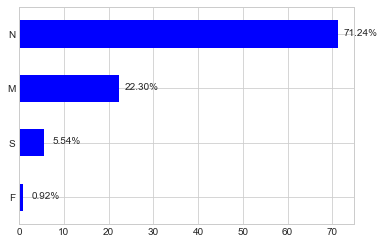

In [6]:
plot_and_annotate(plot_data['crashSeverity'])

The first thing that we notice is the astonishing small number of fatal crashes there has been; considering this is data going back to the year 2000.

Also, it is important to note here –as the NZ Transport Agency warns– that the reporting of crashes increses with their severity. Meaning that all *fatal* crash have been most likely be reported, but that there will be *Non Fatal* and *Minor* crashes that weren't reported. This decision falls somewhat to the person in charge of responding to the crash.

However, the most important thing to notice is how these classes are distributed and the imbalance between them. Since we want to predict these classes, and because the dispatched response would be very different depending on our prediction, we definitely need to be very carefull about how we measure the performance of our model.

To this end, and considering we will be trying different models, we will rely on an array of performance metrics that will help us evaluate and chose the best model for the task. Namely, for each algorithm, we will analyze the following performance metrics:
* Accuracy
* Precision
* Recall
* F-Score
* Specificity
* AUC ROC

Each of these metrics will provide valuable insight into the performance of each model and the aspects each one prioritized.

Finally, due to the lack of balance of these values, we will explore a few techniques to remedy the situation. <span style="color: red">CHECK FOR UNDERSAMPLING N</span>

#### multiVehicle

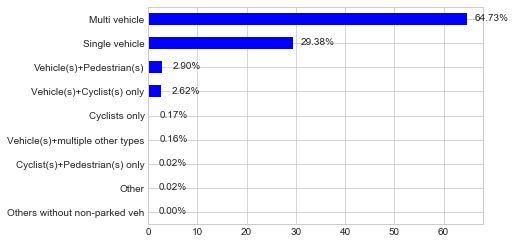

In [7]:
plot_and_annotate(plot_data['multiVehicle'])

This feature doesn't raise any alarm or suspitions with regard to its values. But we do take notice of its distribution. This will be helpful later when we look back into this in combination with other features.

#### holiday

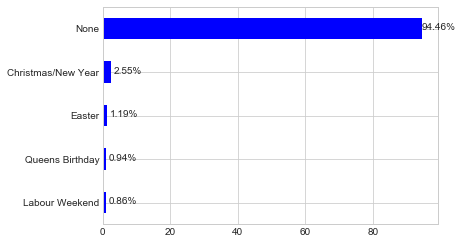

In [8]:
plot_and_annotate(plot_data['holiday'])

Here we see something interesting. A quick search on the web will show that the Kiwis have a descent level of alcohol consumption. In fact, they have some of the finest Pinot Noir of the world. Yet we see that almost all crashes happened on a regular day; as oposed to some holiday. <span style="color:red">Acutally –and we will show this later– this hold regardless of the serverity of the crash.</span>

besides from this observation, the feature doesn't present any abnormalities.

#### regionDesc

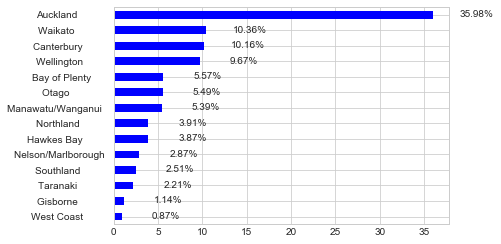

In [9]:
plot_and_annotate(plot_data['regionDesc'])

This features shows fair consistency with population density throughout the country. It will be interesting to see how the other feature behave with regard to this one. More about this later on.

#### tlaName

As the catalog describes, this feature indicates the local authority that oversaw the crash and the following procedures. Therefore, for almost every case, the tlaName will be a district withing the region of the crash.

However, for some cases, the tlaName will be a distrcit that doesn't belong to the region indicated for the crash. We understand that these cases correspond to crashes that happened close to the border between two regions and for some unknown reason, the TLA that responded to the crash was from another region from where the crash happened. We will consider this as of no consequence.

#### intersection

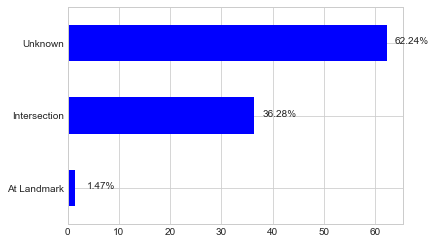

In [10]:
plot_and_annotate(plot_data['intersection'])

This feature doesn't present anything strange or special. One could argue though that the value *Unknown* deserves some special treatment. However, the NZ Transport Agency has defined it in the PDF as a proper value, giving it complete legitamecy.

#### junctionType

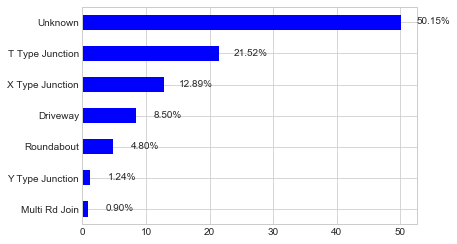

In [11]:
plot_and_annotate(plot_data['junctionType'])

Again, as with *intersection*, the value *Unknown* is completely legitimate. Moreover, these two fetures are used in tandem to define a derived feature *intersectionMidblock*; so we musn't meddle with them.

#### cornerRoadSideRoad

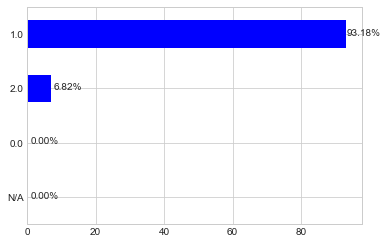

In [12]:
plot_and_annotate(plot_data['cornerRoadSideRoad'])

here we finally see something that required our attention. First, let us clarify that the name of this feature in the dataset corresponds to the feature from the PDF refer to as Crash *Road Side Road (CR_RD_SIDE_RD)*. In the PDF, it says that the possible values are either `1`or `2`. But here we find that there are some cases with values `0` –which comes directly from the dataset– and with `N/A` –which was our way to denote missing values. So we definitely need to take some action in this case. So lets see how many cases do we have for these two values.

In [13]:
plot_data['cornerRoadSideRoad']

,cornerRoadSideRoad,percent
1.0,610996,93.182674
2.0,44696,6.816563
0.0,3,0.000458
N/A,2,0.000305


Ok, so we only have five anomalous cases. three for the value `0` and two that were missing values originally.

One option would be to remove these five samples from the dataset altogether.

Another options would be to fill these cases with an appropriate value. However, we have no criteria to choose such a value. Besides these few cases only represent an infinitesimal portion of the dataset.

As a final check before removing them, let us see what is the creash severity for these cases.

In [21]:
mask = crash_data[crash_data['cornerRoadSideRoad'].isin([0, 'N/A'])]
mask[['cornerRoadSideRoad', 'crashSeverity']]

,cornerRoadSideRoad,crashSeverity
21021,0,N
26595,0,N
547028,N/A,N
583837,N/A,N
630452,0,N


Great. They all correspond to non-injury cases. Since this is the class that is oversampled, we can go ahead and remove them without any significant loss of information.

In [22]:
crash_data.drop(mask.index, inplace=True)

---

#### directionRoleDescription

<span style="color:red">FIXME</span>

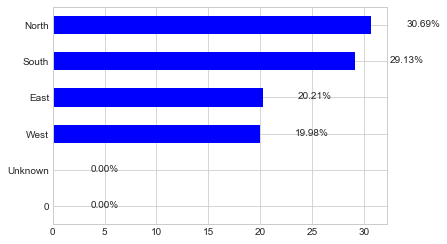

In [23]:
plot_and_annotate(plot_data['directionRoleDescription'])

In [ ]:
plot_data['directionRoleDescription']

In [26]:
mask = crash_data[crash_data['directionRoleDescription'].isin([0, 'unknown'])]
mask[['directionRoleDescription', 'crashSeverity']]

,directionRoleDescription,crashSeverity
